# Satellite Intelligence for Catastrophic Natural Disaster Recovery: Assessing Damage and First Responder Priorities through Geospatial Imagery

## Jeremiah Fa'atiliga, Ravita Kartawinata, Sowmiya Kanmani Maruthavanan

# Importing Libraries

In [97]:
import os
import json
import pandas as pd
import numpy as np
import cv2
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
from shapely import wkt
from shapely.geometry import mapping

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPooling2D, Concatenate, UpSampling2D

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")


The xBD dataset provides annotated high-resolution satellite imagery for assessing building damage, consisting of JSON files and image files. This project focuses on analyzing pre- and post-disaster imagery related to hurricanes.

## Data Loading

In [2]:
# Function to read JSON files
def load_JSON_data(directory):
    pre_data = []
    post_data = []

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            content = json.load(file)

        # Filter by hurricane natural disaster only
        disaster = content['metadata'].get('disaster')
        if disaster and "hurricane" in disaster.lower():
            img_name = content['metadata'].get('img_name', "")
            data = {
                'img_name': img_name,
                'xy': content['features'].get('xy'),
                'sensor': content['metadata'].get('sensor'),
                'provider_asset_type': content['metadata'].get('provider_asset_type'),
                'gsd': content['metadata'].get('gsd'),
                'capture_date': content['metadata'].get('capture_date'),
                'off_nadir_angle': content['metadata'].get('off_nadir_angle'),
                'pan_resolution': content['metadata'].get('pan_resolution'),
                'sun_azimuth': content['metadata'].get('sun_azimuth'),
                'sun_elevation': content['metadata'].get('sun_elevation'),
                'target_azimuth': content['metadata'].get('target_azimuth'),
                'disaster': disaster,
                'disaster_type': content['metadata'].get('disaster_type'),
                'catalog_id': content['metadata'].get('catalog_id'),
                'original_width': content['metadata'].get('original_width'),
                'original_height': content['metadata'].get('original_height'),
                'width': content['metadata'].get('width'),
                'height': content['metadata'].get('height'),
                'id': content['metadata'].get('id')
            }
            
            # Separate pre and post DataFrame
            if "pre" in img_name.lower():
                pre_data.append(data)
            elif "post" in img_name.lower():
                post_data.append(data)
    
    hurricane_pre_df = pd.DataFrame(pre_data)
    hurricane_post_df = pd.DataFrame(post_data)
    
    return hurricane_pre_df, hurricane_post_df

In [3]:
# Setup
#directory_path = "../Data"
directory_path = "C:/Users/sowmi/gitworkspace/hurricane/train/labels"

# Loading JSON data into dataframe
hurricane_pre_df, hurricane_post_df = load_JSON_data(directory_path)

## Loading the images

In [4]:
# Function to load pre- and post- disaster images
def load_images(filename) :
    
    image_path = os.path.join(image_folder, filename)
    
    # Reading the image
    image = cv2.imread(image_path)
    
    # Convert image from BGR to RGB format
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return rgb_image

In [5]:
# S3 Bucket Name & Image Directory Location
S3_Bucket_Name = 'hurricaneimagebucket'  
Image_Directory = '../Images'

# boto3 to initialize S3 client
s3_client = boto3.client('s3')

# S3 Bucket Download Images Function
def S3_Download(S3_Bucket_Name, Image_Directory):
    # Objects list within S3 Bucket
    S3_Response = s3_client.list_objects_v2(Bucket = S3_Bucket_Name)

    # Check if the bucket contains any objects
    if 'Contents' in S3_Response:
        for S3_Object in S3_Response['Contents']:
            file_name = S3_Object['Key']

            # Check if file is .png if want to add other formats i.e. file_name.endswith(('.png','.jpeg'))
            if file_name.endswith('.png'):  # Image format
                # Uncomment line below if you are requiring to see the downloads
                # print(f'Downloading {file_name}...')

                # Join Path
                Image_path = os.path.join(Image_Directory, file_name)

                # Create any necessary directories
                os.makedirs(os.path.dirname(Image_path), exist_ok = True)

                # Download the image
                s3_client.download_file(S3_Bucket_Name, file_name, Image_path)
                # Uncomment line below if you are requiring to see the downloads
                # print(f'Image downloaded {file_name}')
    else:
        print('No images found in the bucket')

# Call the function
S3_Download(S3_Bucket_Name, Image_Directory)

NoCredentialsError: Unable to locate credentials

In [6]:
image_folder = "C:/Users/sowmi/Python scripts/hurricane/images"

pre_hurricane_images = []
pre_image_size = []

post_hurricance_images = []
post_image_size = []

for index, row in hurricane_pre_df.iterrows() :
    img_filename = row['img_name']
    img = load_images(img_filename)
    size = img.shape
    pre_hurricane_images.append(img)
    pre_image_size.append(size)

for index, row in hurricane_post_df.iterrows() :
    img_filename = row['img_name']
    img = load_images(img_filename)
    size = img.shape
    post_hurricance_images.append(img)
    post_image_size.append(size)

In [7]:
# Assigning image size to a new column
hurricane_pre_df['image_size'] = pre_image_size
hurricane_post_df['image_size'] = post_image_size

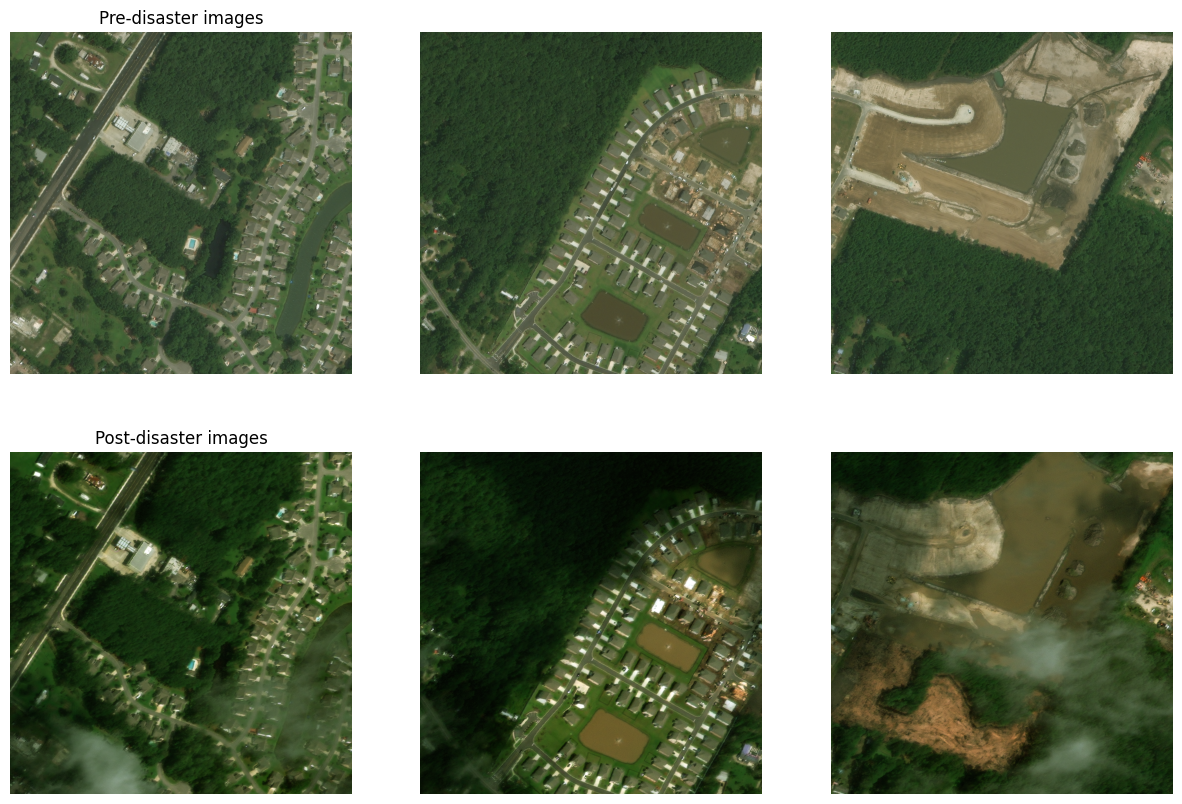

In [8]:
# Displaying the images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display pre-disaster images 
for i in range(3) :
    axes[0, i].imshow(pre_hurricane_images[i])
    axes[0, i].axis('off')

# Display post-disaster images 
for i in range(3) :
    axes[1, i].imshow(post_hurricance_images[i])
    axes[1, i].axis('off')

axes[0,0].set_title("Pre-disaster images")
axes[1,0].set_title("Post-disaster images")
plt.show()

## Exploratory Data Analysis

## Data Preprocessing

### Mask polygons and locate buildings

In [9]:
# Function to get polygon annotations for each building
def get_polygon_annotations(feature) :
    poly_annotations = {}
    
    for feat in feature :
        # Convert string format to polygon object
        feat_shape = wkt.loads(feat['wkt'])
        
        # Extract coordinates of the polygon in a tuple
        coords = list(mapping(feat_shape)['coordinates'][0])
        
        # Store unique id and coordinates for each building as a Numpy array
        poly_annotations[feat['properties']['uid']] = (np.array(coords, np.int32))
        
    return poly_annotations

In [10]:
# Function to locate buildings using polygon annotations
def mask_polygons(size, poly_annotations) :

    # Creating black empty mask image 
    mask_img = np.zeros(size, dtype=np.uint8)
    
    for points in poly_annotations :
        
        # Creating empty mask image to hold one polygon 
        blank_img = np.zeros(size, dtype=np.uint8)
        
        # Extract list of points to locate the building
        poly = poly_annotations[points]
        
        # Fill the blank image with polygon points 
        cv2.fillPoly(blank_img, [poly], (1,1,1))
        
        # Draw the border around the polygon
        cv2.polylines(blank_img, [poly], isClosed=True, color=(2, 2, 2), thickness=2)
        
        # Adding the filled image to the main mask image
        mask_img += blank_img
        
    # Set pixel values greater than 2 to 0 to retain non-overlapping areas
    mask_img[mask_img > 2] = 0
    
    # Convert non-overlapping areas to white to locate buildings
    mask_img[mask_img == 1] = 255
    mask_img[mask_img == 2] = 127
    
    return mask_img

In [11]:
pre_hurricane_mask_images = []

for index, row in hurricane_pre_df.iterrows() :
    feature = row['xy']
    poly_annotations = get_polygon_annotations(feature)
    size = row['image_size']
    mask_image = mask_polygons(size, poly_annotations)
    pre_hurricane_mask_images.append(mask_image)

### Displaying original and masked images

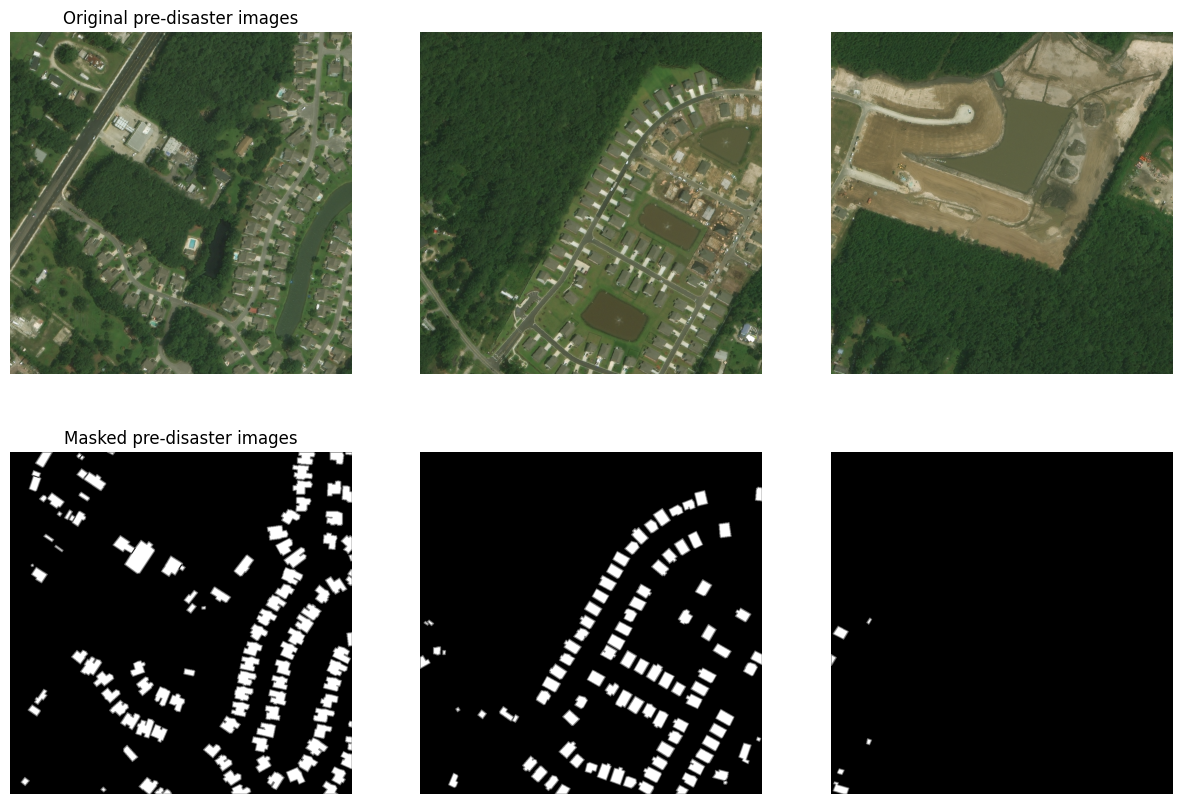

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display original images 
for i in range(3) :
    axes[0, i].imshow(pre_hurricane_images[i])
    axes[0, i].axis('off')

# Display masked images 
for i in range(3) :
    axes[1, i].imshow(pre_hurricane_mask_images[i])
    axes[1, i].axis('off')

axes[0,0].set_title("Original pre-disaster images")
axes[1,0].set_title("Masked pre-disaster images")
plt.show()

In [13]:
# Function to resize images to a standard scale
def resize_images(images, masked=False, target_size=(256, 256)):
    resized_images=[]
    
    for image in images:
        
        # Resize the image to the target dimensions
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        
        if(not masked):
            # Normalize pixel values to the range [0, 1]
            image = image.astype(np.float32) / 255.0
            
        else:
            image = (image > 0).astype(np.uint8)
            if image.shape[2] == 3:
                # Convert from 3 channels to 1 channel 
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Expand dimensions to single channel shape
                image = np.expand_dims(image, axis=-1)
        resized_images.append(image)
    
    return resized_images

In [14]:
pre_resized_img = resize_images(pre_hurricane_images)
pre_mask_resized_img = resize_images(pre_hurricane_mask_images, masked=True)

## Data Partitioning

In [15]:
# Convert lists to Numpy arrays 
X = np.array(pre_resized_img)
y = np.array(pre_mask_resized_img)


In [16]:
print(X.shape)
print(y.shape)

(1219, 256, 256, 3)
(1219, 256, 256, 1)


In [20]:
# Split into training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling for building localization

## Fully Convolutional Network (FCN)

In [86]:
def fcn_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)  # 1-channel output for binary mask

    model = tf.keras.Model(inputs, outputs)
    return model

In [87]:
# Instantiate the model
fcn_model = fcn_model((256, 256, 3))

In [88]:
# Compile the model
fcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [99]:
# Training the model
batch_size = 16
epochs = 20

history = fcn_model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.9415 - loss: 0.1454 - val_accuracy: 0.9402 - val_loss: 0.1492
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.9420 - loss: 0.1456 - val_accuracy: 0.9417 - val_loss: 0.1461
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.9471 - loss: 0.1343 - val_accuracy: 0.9401 - val_loss: 0.1587
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.9460 - loss: 0.1375 - val_accuracy: 0.9442 - val_loss: 0.1457
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.9474 - loss: 0.1355 - val_accuracy: 0.9439 - val_loss: 0.1452
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.9491 - loss: 0.1305 - val_accuracy: 0.9434 - val_loss: 0.1418
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.9496 - loss: 0.1263 - val_accuracy: 0.9377 - val_loss: 0.1563
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.9490 - loss: 0.1301 - val_accuracy: 0.9444 - v

In [100]:
# Making predictions
fcn_predicted_mask = fcn_model.predict(X_test)

# Model Evaluation
loss, accuracy = fcn_model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 902ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 902ms/step - accuracy: 0.9549 - loss: 0.1182
Validation Loss: 0.1257
Validation Accuracy: 0.9514


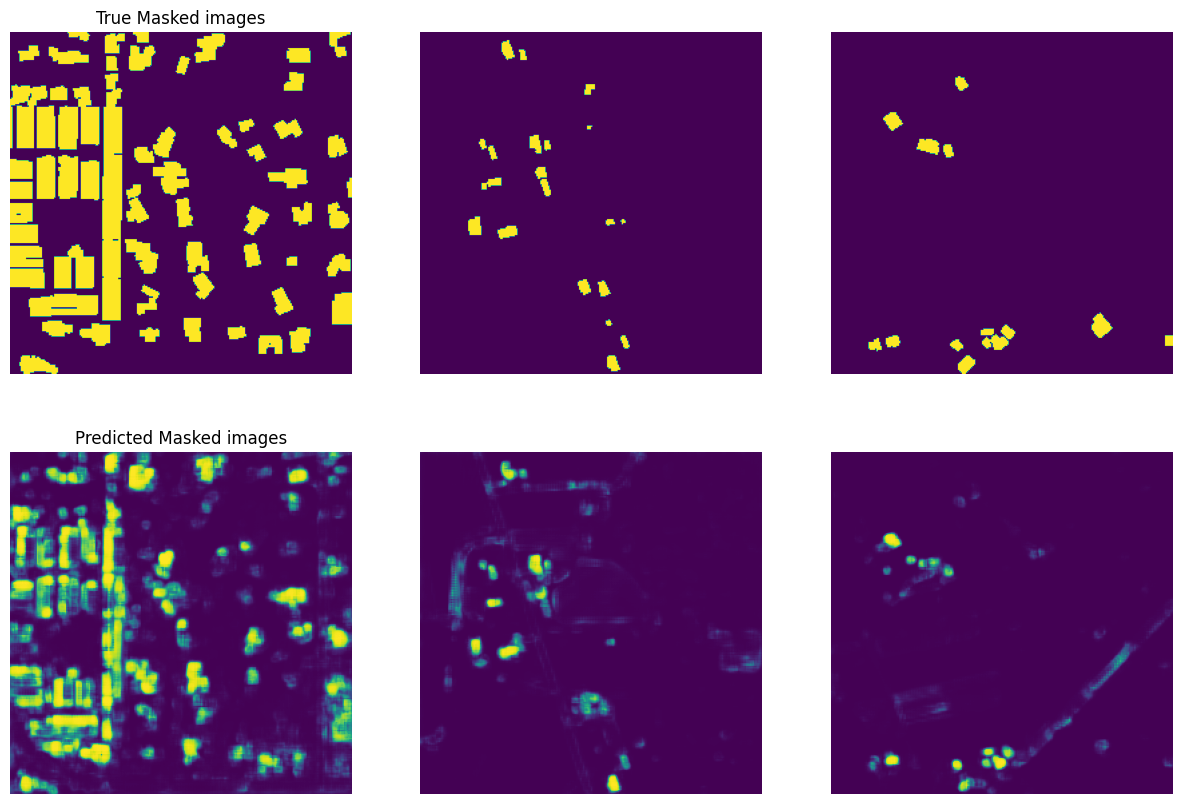

In [101]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display true masked images 
for i in range(3) :
    axes[0, i].imshow(y_test[i])
    axes[0, i].axis('off')

# Display Predicted masked images 
for i in range(3) :
    axes[1, i].imshow(fcn_predicted_mask[i])
    axes[1, i].axis('off')

axes[0,0].set_title("True Masked images")
axes[1,0].set_title("Predicted Masked images")
plt.show()

## U-Net Model

### Conv Block

In [61]:
def Unet_conv_block(inputs, num_filters) :
    """Convolution layer with 3x3 filter 
    followed by BatchNormalization 
    and ReLU activation"""
    
    x = Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

In [68]:
inputs = tf.keras.Input((256, 256, 3))
x = Unet_conv_block(inputs, 32)
print(x.shape)

(None, 256, 256, 32)


### Encoder Block

In [62]:
def Unet_encoder_block(inputs, num_filters) :
    
    x = Unet_conv_block(inputs, num_filters)
    # Max pooling with 2x2 filter
    x = MaxPooling2D((2,2))(x)
    
    return x

In [71]:
inputs = tf.keras.Input((256, 256, 3))
x = Unet_encoder_block(inputs, 32)
print(x.shape)

(None, 128, 128, 32)


### Decoder Block

In [90]:
def Unet_decoder_block(inputs, num_filters, skip) :
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    
    # Check the dimension of upsampled output and skip connection
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
        skip = UpSampling2D((2, 2))(skip)
        
    x = Concatenate()([x, skip])
    x = Unet_conv_block(x, num_filters)
    
    return x

In [92]:
inputs = tf.keras.Input((256, 256, 3))
skip = tf.keras.Input((512, 512, 3))
x = Unet_decoder_block(inputs, 32, skip)
print(x.shape)

(None, 512, 512, 32)


In [93]:
def build_unet_model(input_shape) :
    inputs = tf.keras.Input(input_shape)
    
    # Encoders
    encoder1 = Unet_encoder_block(inputs, 64)
    encoder2 = Unet_encoder_block(encoder1, 128)
    encoder3 = Unet_encoder_block(encoder2, 256)
    encoder4 = Unet_encoder_block(encoder3, 512)
    
    # Bottleneck
    bridge1 = Unet_conv_block(encoder4, 1024)
    
    # Decoders
    decoder1 = Unet_decoder_block(bridge1, 512, encoder4)
    decoder2 = Unet_decoder_block(decoder1, 256, encoder3)
    decoder3 = Unet_decoder_block(decoder2, 128, encoder2)
    decoder4 = Unet_decoder_block(decoder3, 64, encoder1)
    
    # Output
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(decoder4)
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

In [98]:
# Instantiate the model
unet_model = build_unet_model((256, 256, 3))
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)   │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_129 (Conv2D)           │ (None, 256, 256, 64)      │           1,792 │ input_layer_36[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_126       │ (None, 256, 256, 64)      │             256 │ conv2d_129[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_126 (Activation)   │ (None, 256, 256, 64)      │               0 │ batch_normalization_126[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_130 (Conv2D)           │ (None, 256, 256, 64)      │          36,928 │ activation_126[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_127       │ (None, 256, 256, 64)      │             256 │ conv2d_130[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_127 (Activation)   │ (None, 256, 256, 64)      │               0 │ batch_normalization_127[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_46              │ (None, 128, 128, 64)      │               0 │ activation_127[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_131 (Conv2D)           │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d_46[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_128       │ (None, 128, 128, 128)     │             512 │ conv2d_131[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_128 (Activation)   │ (None, 128, 128, 128)     │               0 │ batch_normalization_128[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_132 (Conv2D)           │ (None, 128, 128, 128)     │         147,584 │ activation_128[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_129       │ (None, 128, 128, 128)     │             512 │ conv2d_132[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_129 (Activation)   │ (None, 128, 128, 128)     │               0 │ batch_normalization_129[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_47              │ (None, 64, 64, 128)       │               

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [99]:
# Compile the model
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [101]:
# Training the model
batch_size = 16
epochs = 20

history = unet_model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1423s 23s/step - accuracy: 0.8971 - loss: 0.3206 - val_accuracy: 0.1054 - val_loss: 7.4466
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1317s 22s/step - accuracy: 0.9435 - loss: 0.1564 - val_accuracy: 0.9085 - val_loss: 0.3361
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1130s 18s/step - accuracy: 0.9459 - loss: 0.1397 - val_accuracy: 0.9085 - val_loss: 0.3797
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1038s 17s/step - accuracy: 0.9523 - loss: 0.1255 - val_accuracy: 0.8430 - val_loss: 0.4590
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1046s 17s/step - accuracy: 0.9533 - loss: 0.1198 - val_accuracy: 0.9200 - val_loss: 0.2334
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1036s 17s/step - accuracy: 0.9555 - loss: 0.1158 - val_accuracy: 0.9090 - val_loss: 0.5900
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1037s 17s/step - accuracy: 0.9571 - loss: 0.1123 - val_accuracy: 0.9238 - val_loss: 0.2617
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1039s 17s/step - accuracy: 0.9589 - loss: 0.1050 - val_accu

In [1]:
# Making predictions
unet_predicted_mask = unet_model.predict(X_test)

# Model Evaluation
loss, accuracy = unet_model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

NameError: name 'unet_model' is not defined